# Data Exploration - early decision notes

This notebook details decisions and steps made during data preparation phase.
- it is not intended as a final report
- it is in *note* format
- it may contain my thought process, including outstanding questions and issues
- it may contain next steps, ideas or musings



### Import libraries

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt

### File and Prediction point

In [5]:
# path to zip file
zipfile_ou = '../../data/anonymisedData.zip'

# prediction point - days from start of course
prediction_point = None

### Load Data
- registrations
- courses
- students
- student_vle
- vle
- student_assessments
- assessments

In [3]:
# load files

def load_data(zip_file_path):
    '''Loads the data from the Open University Learning Analytics dataset zip file.'''
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        registrations = pd.read_csv(zip_file.open('studentRegistration.csv'))
        courses = pd.read_csv(zip_file.open('courses.csv'))
        students = pd.read_csv(zip_file.open('studentInfo.csv'))
        student_vle = pd.read_csv(zip_file.open('studentVle.csv'))
        vle = pd.read_csv(zip_file.open('vle.csv'))
        student_assessments = pd.read_csv(zip_file.open('studentAssessment.csv'))
        assessments = pd.read_csv(zip_file.open('assessments.csv'))
    
    return registrations, courses, students, student_vle, vle, student_assessments, assessments

In [6]:
registrations, courses, students, student_vle, vle, student_assessments, assessments = load_data(zipfile_ou)

## Initial Data Exploration

In [6]:
def csv_basics(df, exclude_columns=None, box=True):
    '''
    Function prints basic details - rows, cols, missing vals, summary stats, and optional boxplots. 
    Option to exclude columns.
    '''

    if exclude_columns:
        df = df.drop(exclude_columns, axis=1)

    num_rows = df.shape[0]
    num_columns = df.shape[1]
    print("Number of rows:", num_rows, "\n")
    print("Number of columns:", num_columns, "\n")

    missing_values = df.isnull().sum()
    print("Missing values:\n", missing_values, "\n")

    summary_stats = df.describe()
    print("Summary statistics:\n", summary_stats, "\n")

    if box:
        df.boxplot()
        plt.show()

### students

- 1111 rows missing `imd_band` data (3.4%)
  - is this missing at random?
  - suspect not given the question topic.

**Decision** - drop these rows.  
- It is under 5% of the total row and there is no chance of collecting it.  I also do not know enough to consider any imputation.  
- Alternative, is to drop the feature but I wonder whether it will be useful in the model, or an unsupervised clustering model.



Number of rows: 32593 

Number of columns: 11 

Missing values:
 code_module                0
code_presentation          0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64 

Summary statistics:
        num_of_prev_attempts  studied_credits
count          32593.000000     32593.000000
mean               0.163225        79.758691
std                0.479758        41.071900
min                0.000000        30.000000
25%                0.000000        60.000000
50%                0.000000        60.000000
75%                0.000000       120.000000
max                6.000000       655.000000 



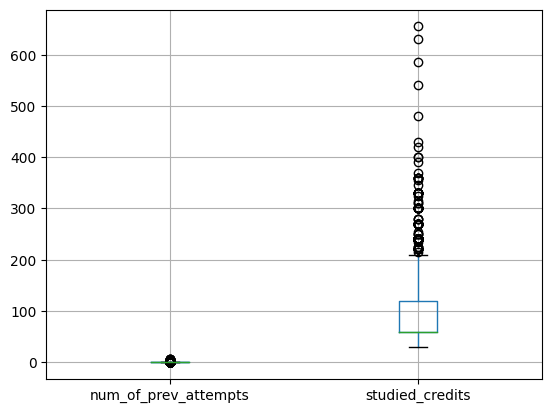

In [7]:
csv_basics(students, exclude_columns="id_student")

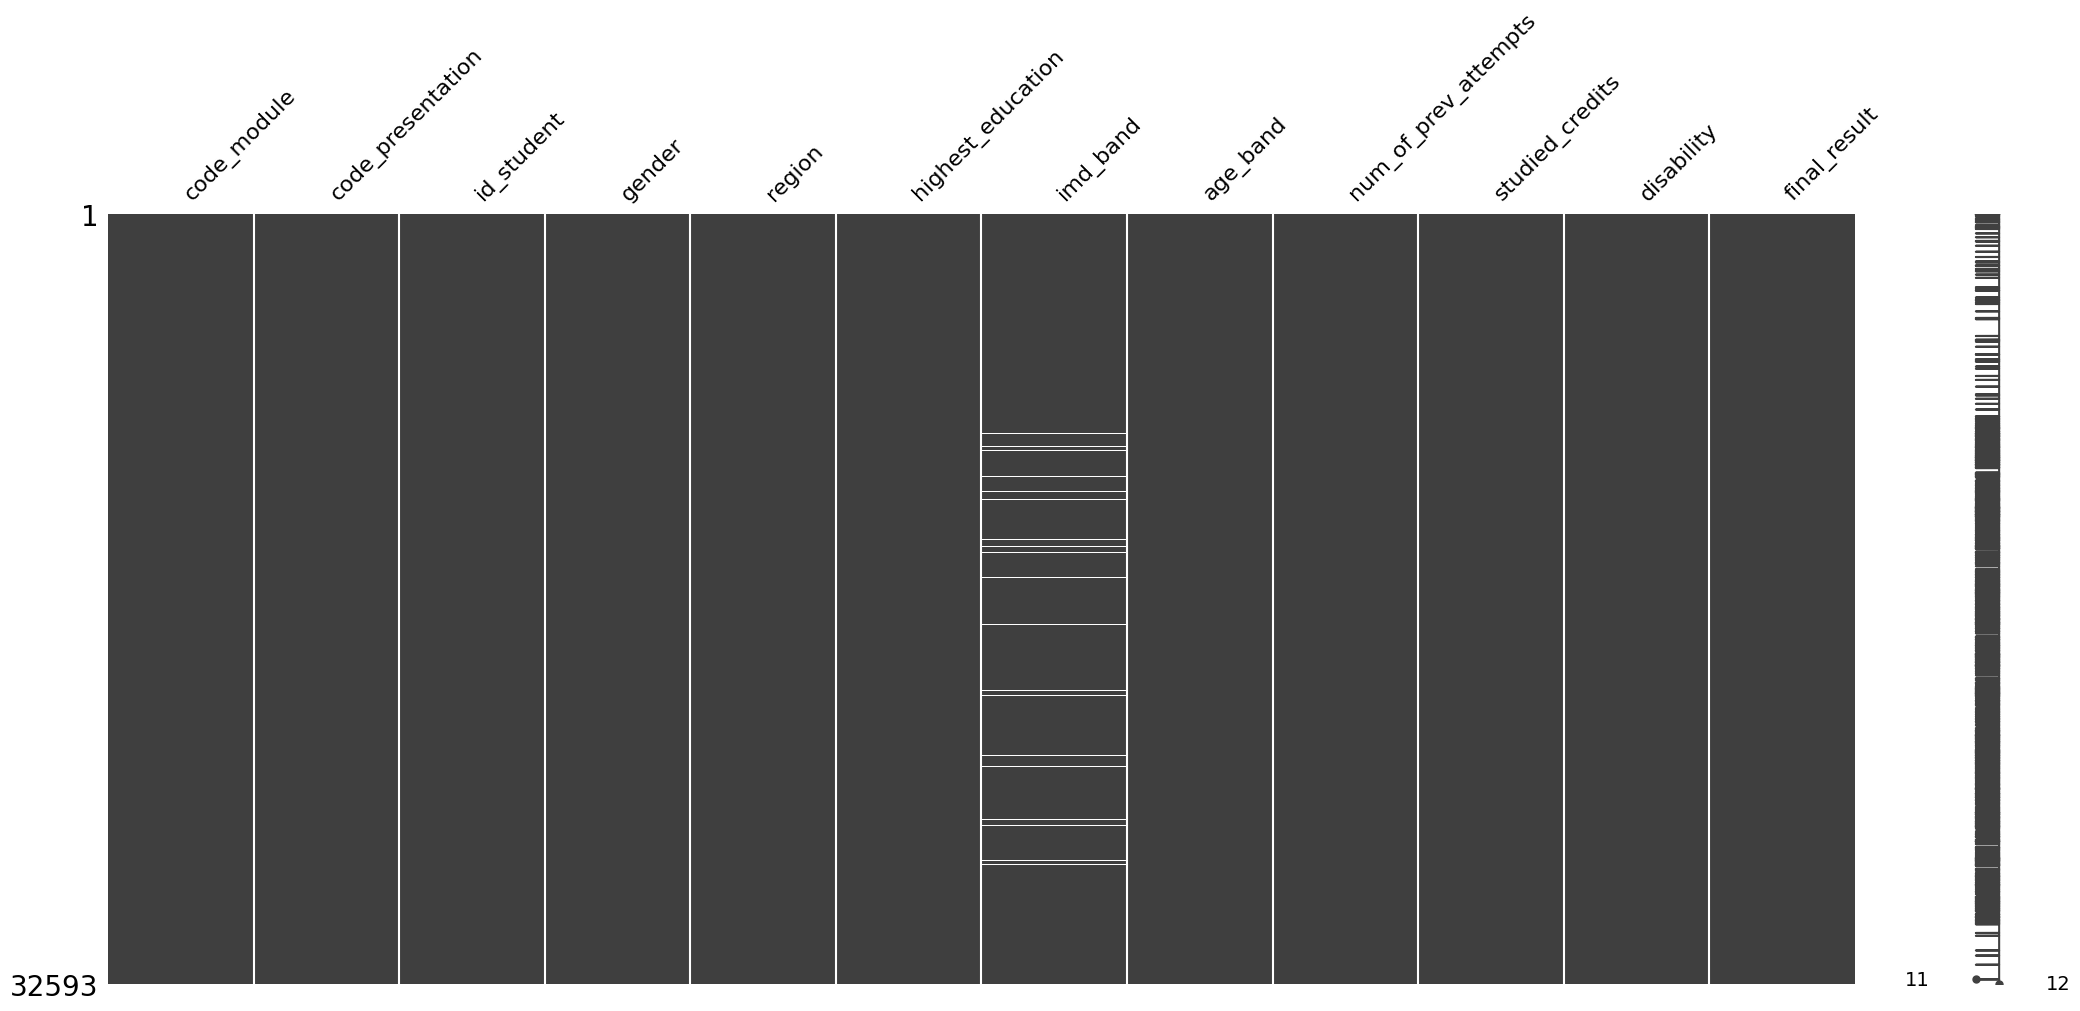

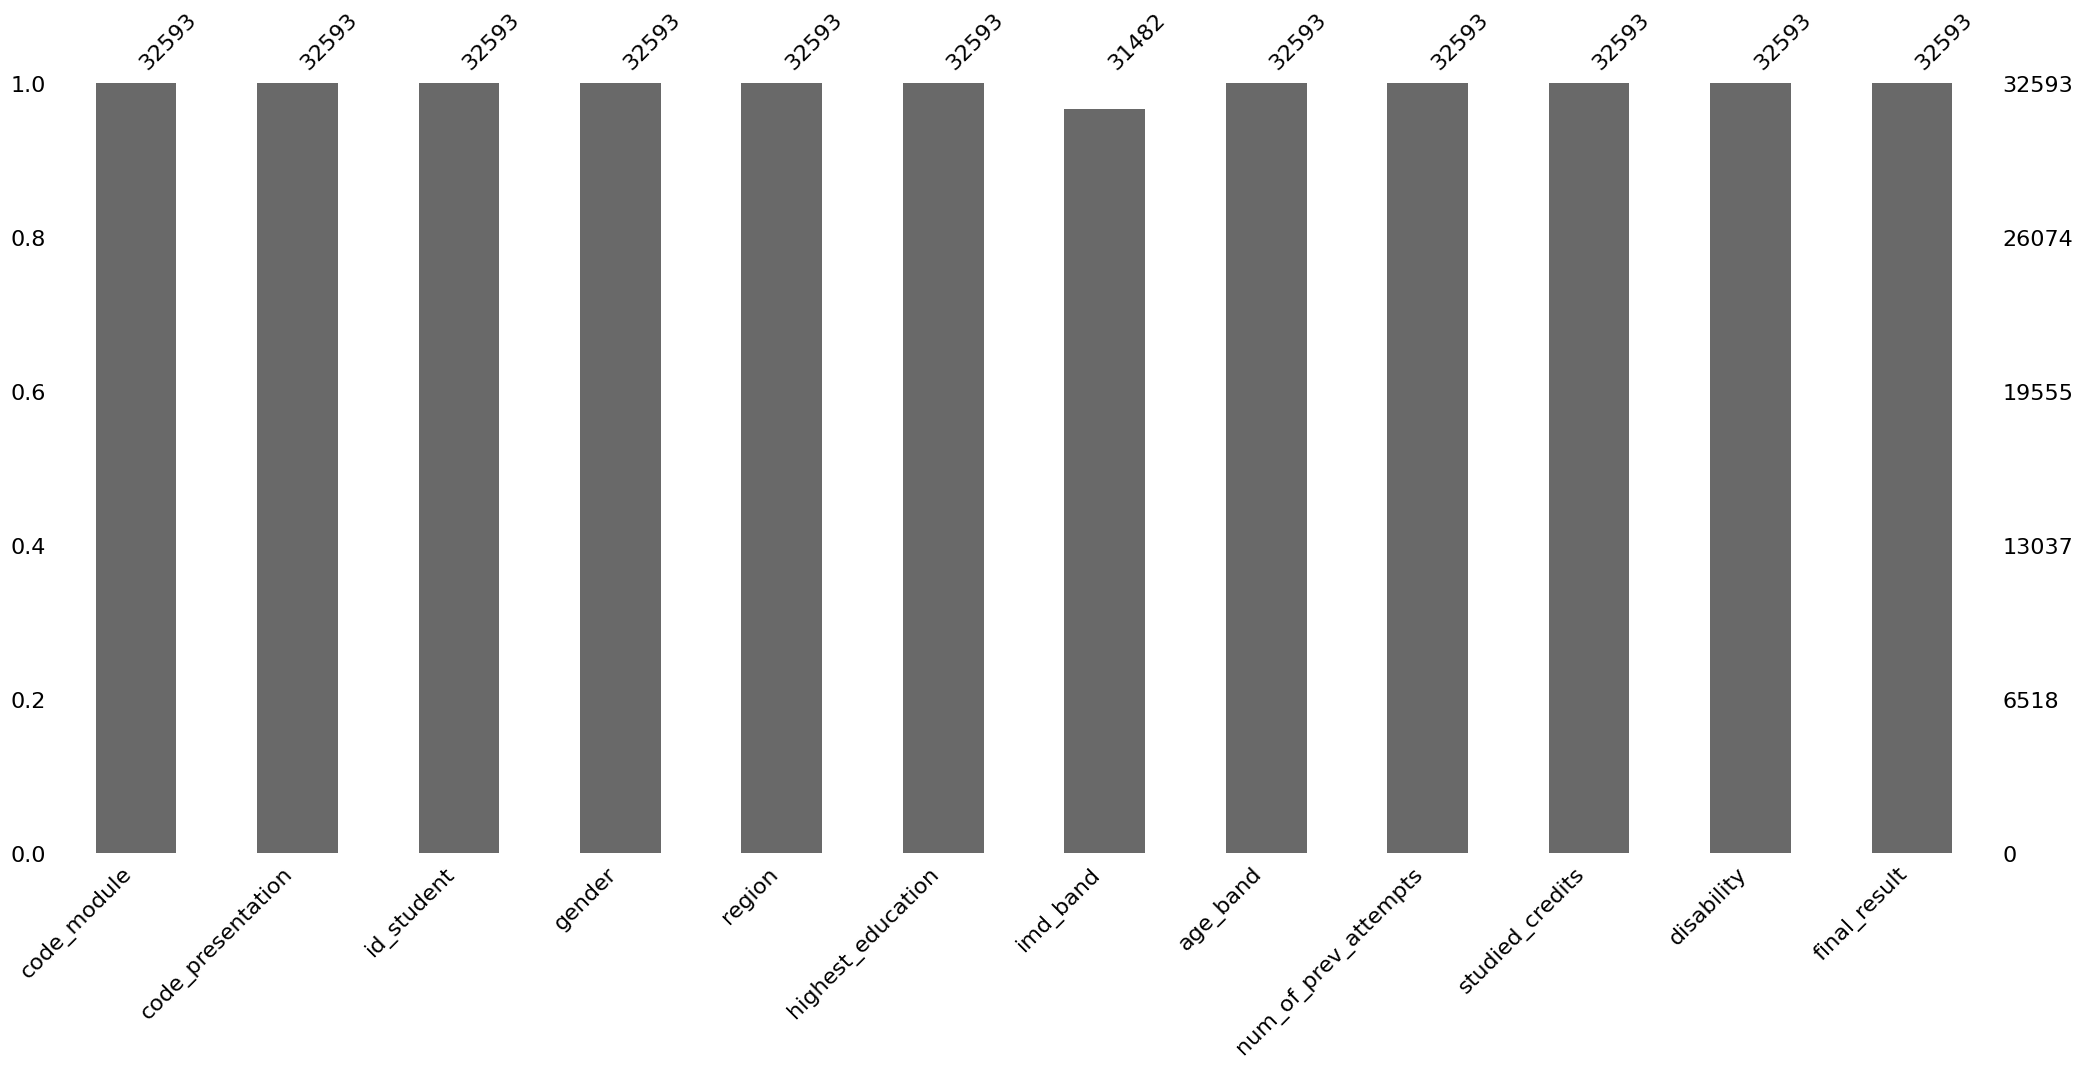

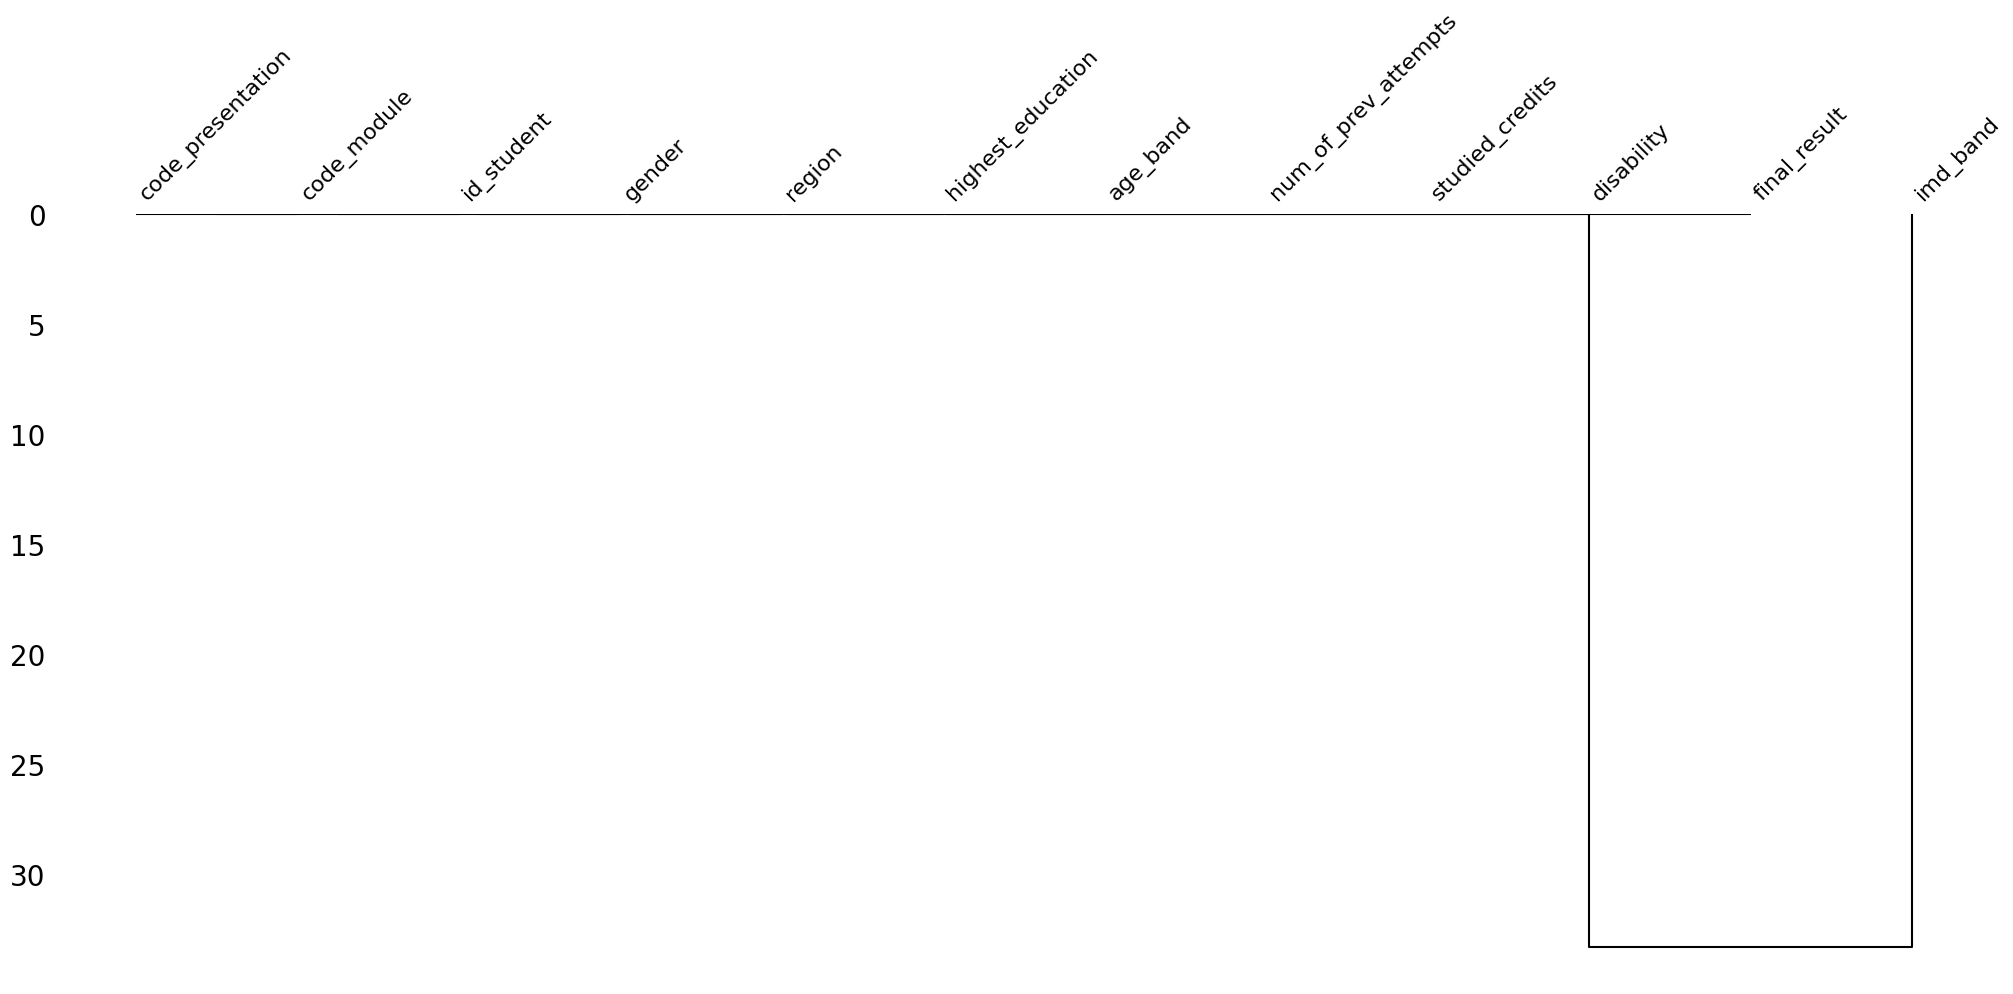

In [8]:
#%pip install missingno
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(students)
plt.show()

msno.bar(students)
plt.show()

msno.dendrogram(students)
plt.show()

### registrations

- need to merge with students to get dates - registration and unregistration dates
- 45 do not have a registration date - likely to need deletion as cannot be considered if not registered and a small number
- 22521 missing date_unregistration - this needs to be imputed (finish of course) - this students are still registered (completing)

Number of rows: 32593 

Number of columns: 4 

Missing values:
 code_module                0
code_presentation          0
date_registration         45
date_unregistration    22521
dtype: int64 

Summary statistics:
        date_registration  date_unregistration
count       32548.000000         10072.000000
mean          -69.411300            49.757645
std            49.260522            82.460890
min          -322.000000          -365.000000
25%          -100.000000            -2.000000
50%           -57.000000            27.000000
75%           -29.000000           109.000000
max           167.000000           444.000000 



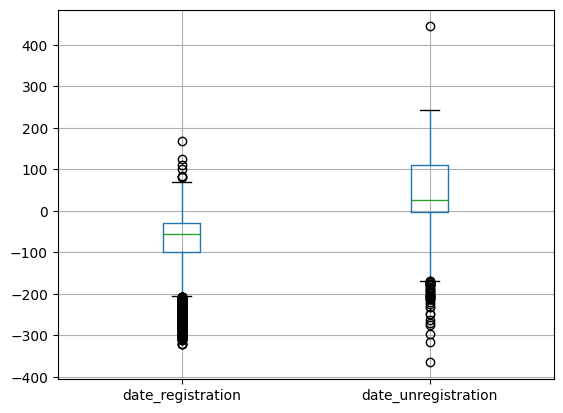

In [9]:
csv_basics(registrations, exclude_columns="id_student")

### explore registration dates

- students should not be able to unregister before registering
- students who unregister on the same day as registering should be excluded
- consider 'cooling off' period - students who unregister within X days of registering should be excluded - 14, 21 days?

For example - there are 447 students who unregister within 14 days of registering.

**Decision** - excluding students who unregister before starting but keeping the rest for the initial model. I don't want to make any assumptions and it is valuable to see whether these students can be identified/predicted from the features.  



In [10]:


# unregistration before or on the same day as registration
registrations['unregistration_before_registration'] = registrations['date_unregistration'] <= registrations['date_registration']

# print unreg <= reg rows
unreg_before_reg = registrations[registrations['unregistration_before_registration'] == True]
#print(unreg_before_reg.head(20))

# unregistration before registration date + 14 (two weeks cool off)
registrations['unregistration_before_registration_14_days'] = registrations['date_unregistration'] <= registrations['date_registration'] + 14

# print unreg <= reg rows
unreg_before_reg_14_days = registrations[registrations['unregistration_before_registration_14_days'] == True]
#print(unreg_before_reg_14_days.head(20))
print(unreg_before_reg_14_days.count())

code_module                                   447
code_presentation                             447
id_student                                    447
date_registration                             447
date_unregistration                           447
unregistration_before_registration            447
unregistration_before_registration_14_days    447
dtype: int64


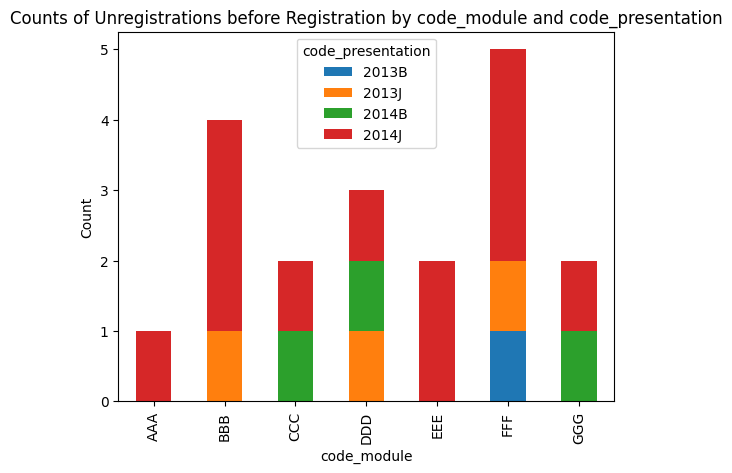

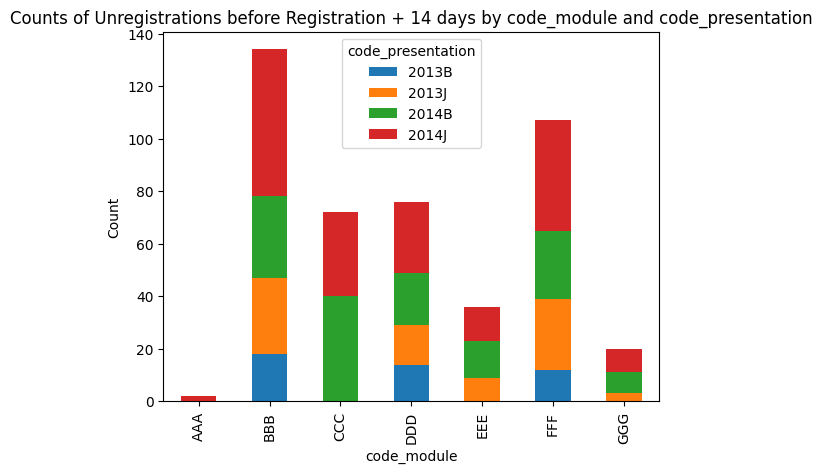

In [13]:
import matplotlib.pyplot as plt

# group  data by code_module and code_presentation, calculate the counts
grouped_counts = unreg_before_reg.groupby(['code_module', 'code_presentation']).size().unstack()

# grouped bar plot
grouped_counts.plot(kind='bar', stacked=True)
plt.xlabel('code_module')
plt.ylabel('Count')
plt.title('Counts of Unregistrations before Registration by code_module and code_presentation')
plt.legend(title='code_presentation')
plt.show()



# group  data by code_module and code_presentation, calculate the counts
grouped_counts_14 = unreg_before_reg_14_days.groupby(['code_module', 'code_presentation']).size().unstack()

# grouped bar plot
grouped_counts_14.plot(kind='bar', stacked=True)
plt.xlabel('code_module')
plt.ylabel('Count')
plt.title('Counts of Unregistrations before Registration + 14 days by code_module and code_presentation')
plt.legend(title='code_presentation')
plt.show()


### courses

- presentation should be split into year, intake month

Number of rows: 22 

Number of columns: 3 

Missing values:
 code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64 

Summary statistics:
        module_presentation_length
count                   22.000000
mean                   255.545455
std                     13.654677
min                    234.000000
25%                    241.000000
50%                    261.500000
75%                    268.000000
max                    269.000000 



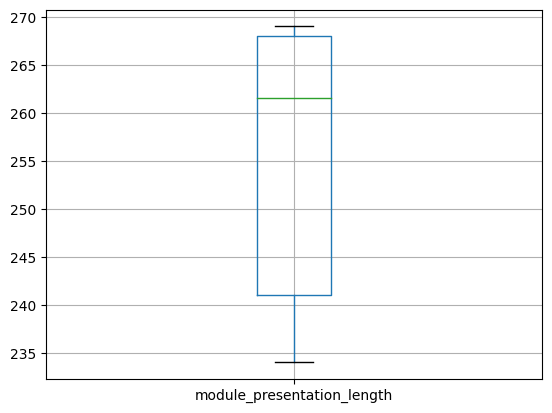

   code_module code_presentation  module_presentation_length
0          AAA             2013J                         268
1          AAA             2014J                         269
2          BBB             2013J                         268
3          BBB             2014J                         262
4          BBB             2013B                         240
5          BBB             2014B                         234
6          CCC             2014J                         269
7          CCC             2014B                         241
8          DDD             2013J                         261
9          DDD             2014J                         262
10         DDD             2013B                         240
11         DDD             2014B                         241
12         EEE             2013J                         268
13         EEE             2014J                         269
14         EEE             2014B                         241
15         FFF          

In [14]:
csv_basics(courses)
print(courses)

In [17]:


# split code_presentation into year and intake columns
registrations['year'] = registrations['code_presentation'].str[:4].astype(int)
registrations['intake'] = registrations['code_presentation'].str[-1].map({'J': 'Oct', 'B': 'Feb'})


# module subject mapping
code_module_mapping = {
    'AAA': 'SocSci',
    'BBB': 'SocSci',
    'GGG': 'SocSci',
    'CCC': 'Stem',
    'DDD': 'Stem',
    'EEE': 'Stem',
    'FFF': 'Stem'
}
registrations['module_category'] = registrations['code_module'].map(code_module_mapping)

# print
print(registrations[['code_module', 'code_presentation', 'year', 'intake', 'module_category']].groupby(['code_module', 'code_presentation', 'year', 'intake', 'module_category']).size().unstack())


module_category                            SocSci    Stem
code_module code_presentation year intake                
AAA         2013J             2013 Oct      383.0     NaN
            2014J             2014 Oct      365.0     NaN
BBB         2013B             2013 Feb     1767.0     NaN
            2013J             2013 Oct     2237.0     NaN
            2014B             2014 Feb     1613.0     NaN
            2014J             2014 Oct     2292.0     NaN
CCC         2014B             2014 Feb        NaN  1936.0
            2014J             2014 Oct        NaN  2498.0
DDD         2013B             2013 Feb        NaN  1303.0
            2013J             2013 Oct        NaN  1938.0
            2014B             2014 Feb        NaN  1228.0
            2014J             2014 Oct        NaN  1803.0
EEE         2013J             2013 Oct        NaN  1052.0
            2014B             2014 Feb        NaN   694.0
            2014J             2014 Oct        NaN  1188.0
FFF         20

### assessments

My first thought was to exclude these, but of course, they are pertinent and useful for the model.  They are very much a key indicator to performance and engagement - probably especially useful to HE like OU which is virtual and are missing other engagement indicators.

Missing dates have been imputed with the last week of course - as per the literature (final assessments which have not been entered yet)

Number of rows: 206 

Number of columns: 5 

Missing values:
 code_module          0
code_presentation    0
assessment_type      0
date                 0
weight               0
dtype: int64 

Summary statistics:
              date      weight
count  206.000000  206.000000
mean   150.805825   20.873786
std     77.946393   30.384224
min     12.000000    0.000000
25%     81.250000    0.000000
50%    159.000000   12.500000
75%    227.000000   24.250000
max    266.000000  100.000000 



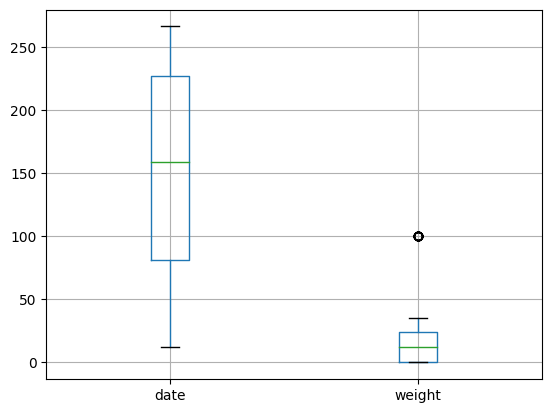

In [18]:
#csv_basics(assessments, exclude_columns="id_assessment")


# merge 'assessments' and 'courses' on 'code_module' and 'code_presentation'
merged_assess = assessments.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], on=['code_module', 'code_presentation'], how='left')

# value to fill in the missing 'date' values
value_to_fill = merged_assess['module_presentation_length'] - 3

# missing values in 'date' column 
merged_assess['date'] = merged_assess['date'].fillna(value_to_fill)

# Update 'assessments' DataFrame with the filled 'date' column
assessments['date'] = merged_assess['date']




csv_basics(assessments, exclude_columns="id_assessment")


### thoughts

It has been clear that I need a mechanism which splits the data on a point in time - a prediction point based on days from the start of course.  

One objective of a Learner Analytics model is to predict outcome (performance or success or continuation) - depending on perspective (student (graduation), institution (retention), government (statutory reporting)) - the early this is done, the more chance there is of intervention and course correction (pun!).

Predicting outcome in the student's last week is not useful.  (Although it could be useful for future cohorts of students with similar characteristics, perhaps, or as carrot/stick).

### assessment features

new features could include: 
- number of assessments or submitted assessments / total assessments for a proportion
- assessment submission dates difference to assessment due dates - some distance measure

The number of assessments per module_presentation differ quite a bit - i.e. 6 for AAA and 13 for FFF

In [19]:
# group by 'code_module' and 'code_presentation' and counting unique 'id_assessment'
counts = assessments.groupby(['code_module','code_presentation' ])['id_assessment'].nunique()

print(counts)


code_module  code_presentation
AAA          2013J                 6
             2014J                 6
BBB          2013B                12
             2013J                12
             2014B                12
             2014J                 6
CCC          2014B                10
             2014J                10
DDD          2013B                14
             2013J                 7
             2014B                 7
             2014J                 7
EEE          2013J                 5
             2014B                 5
             2014J                 5
FFF          2013B                13
             2013J                13
             2014B                13
             2014J                13
GGG          2013J                10
             2014B                10
             2014J                10
Name: id_assessment, dtype: int64


## student assessments

What to do with missing scores? 173 rows with missing score

Delete in the first model



Remove `is_banked` 



Number of rows: 173912 

Number of columns: 8 

Missing values:
 date_submitted         0
is_banked              0
score                173
code_module            0
code_presentation      0
assessment_type        0
date                   0
weight                 0
dtype: int64 

Summary statistics:
        date_submitted      is_banked          score           date  \
count   173912.000000  173912.000000  173739.000000  173912.000000   
mean       116.032942       0.010977      75.799573     132.677584   
std         71.484148       0.104194      18.798107      79.031959   
min        -11.000000       0.000000       0.000000      12.000000   
25%         51.000000       0.000000      65.000000      54.000000   
50%        116.000000       0.000000      80.000000     131.000000   
75%        173.000000       0.000000      90.000000     222.000000   
max        608.000000       1.000000     100.000000     266.000000   

              weight  
count  173912.000000  
mean       12.743899  

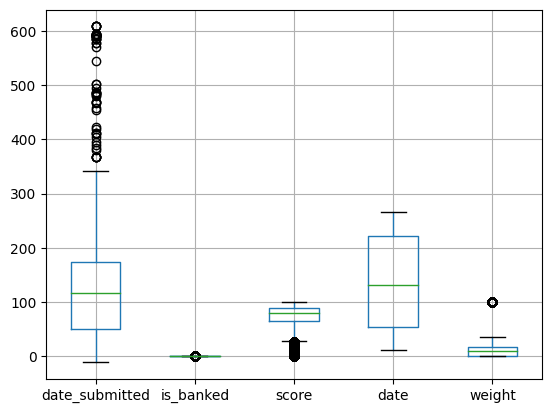

In [21]:
assessments_combined = pd.merge(student_assessments, assessments, on= 'id_assessment')
#print(assessments_combined.head(20))
csv_basics(assessments_combined, exclude_columns= ["id_assessment", "id_student"])

### More assessment thoughts

For the purposes of this assignment, I need to ensure that I have something to show by the due date - I need to get to the starting line with a dataset!

So for **Version 1** - I will create a dataset with new features which are applicable to all students and all module_presentations - ie.. average score (which is relevant whether you have 1 or 13 assessments)

For fuure versions - I wonder if the data can be made *wide* from *long* - but this might mean that each module needs its own model - which is less useful. 

I suppose the question is a business one:

- Do you want a model which is generalisable to predict a student's performance/outcome?  E.g. programmatic or a combination of all registrations?
  - Module_presentations need to be scaled so that they are comparable
- Do you want a model which is generalisable to predict a student's performance/outcome for a specific module?  
  - Module_presentations are features in the model
  - A student will have different outcomes for each module_presentation registration

### Assessment dates

There is some weirdness with dates, in terms of outliers.  I need to investigate this further...or make some rules/assumptions to drop them.

For example - you cannot feasibly submit an assessment for a module_presentation which has finished, or hundreds of days before the assessment was due, or hundreds of days after the assessment was due.



        date_submitted   date  date_diff
0                   18   19.0        1.0
1                   22   19.0       -3.0
2                   17   19.0        2.0
3                   26   19.0       -7.0
4                   19   19.0        0.0
...                ...    ...        ...
173907             227  229.0        2.0
173908             229  229.0        0.0
173909             215  229.0       14.0
173910             230  229.0       -1.0
173911             224  229.0        5.0

[173912 rows x 3 columns]


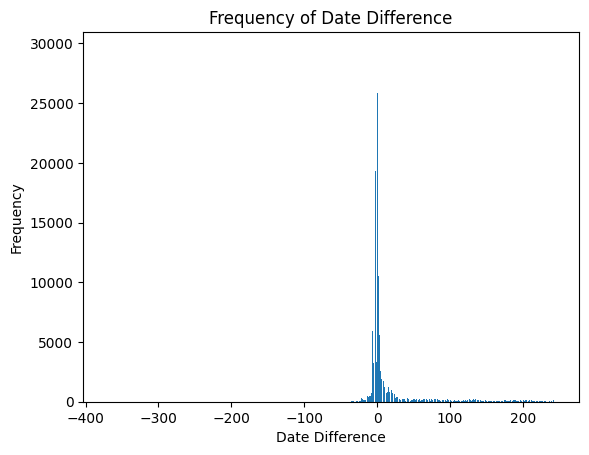

        date_submitted   date  date_diff
46                  54   19.0      -35.0
153                 58   19.0      -39.0
230                 50   19.0      -31.0
375                106   54.0      -52.0
492                 95   54.0      -41.0
...                ...    ...        ...
173557             198  229.0       31.0
173562             198  229.0       31.0
173563             203  229.0       26.0
173566             200  229.0       29.0
173567             207  229.0       22.0

[29862 rows x 3 columns]
       date_submitted          date     date_diff
count    29862.000000  29862.000000  29862.000000
mean       126.529770    220.119483     93.589713
std         72.772243     45.260513     69.230342
min        -11.000000     12.000000   -372.000000
25%         65.000000    222.000000     36.000000
50%        139.000000    229.000000     79.000000
75%        186.000000    236.000000    142.000000
max        608.000000    266.000000    246.000000


In [22]:
## dates details

# new df with date columns
new_df = assessments_combined[['date_submitted', 'date']].copy()

#  date difference column
new_df['date_diff'] = new_df['date'] - new_df['date_submitted']

# print
print(new_df)

# frequency table 
frequency_table = new_df['date_diff'].value_counts()

# plot the frequencies
plt.bar(frequency_table.index, frequency_table.values)

#  labels and title
plt.xlabel('Date Difference')
plt.ylabel('Frequency')
plt.title('Frequency of Date Difference')

# plot
plt.show()

# filter on the absolute difference (21 days)
filtered_df = new_df[abs(new_df['date_diff']) > 21]

# print
print(filtered_df)

print(filtered_df.describe())


In [24]:
# Merge 'student_assessments' with 'courses' to get the course length
merged_data = assessments_combined.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], 
                                       on=['code_module', 'code_presentation'], how='left')

# Calculate the maximum allowed date based on course length
merged_data['max_allowed_date'] = merged_data['module_presentation_length'] + 5

# Count the number of negative date_submitted values
count_negative_dates = merged_data[merged_data['date_submitted'] < 0].shape[0]

# Count the number of date_submitted values that are significantly larger than the due date
count_large_dates = merged_data[merged_data['date_submitted'] > merged_data['max_allowed_date']].shape[0]

# Print the counts
print("Count of Negative date_submitted values:", count_negative_dates)
print("Count of date_submitted values 5 days after course end:", count_large_dates)




Count of Negative date_submitted values: 2057
Count of date_submitted values 5 days after course end: 77


### VLEs

This is the classic `engagement` data, especially for a distance learning institution.  It is the proxy for all engagement with the course. 

Drop `week_from` and `week_to` - they are not useful for the model.  



Number of rows: 6364 

Number of columns: 6 

Missing values:
 id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64 

Summary statistics:
             id_site    week_from      week_to
count  6.364000e+03  1121.000000  1121.000000
mean   7.260991e+05    15.204282    15.214987
std    1.283151e+05     8.792865     8.779806
min    5.267210e+05     0.000000     0.000000
25%    6.615928e+05     8.000000     8.000000
50%    7.300965e+05    15.000000    15.000000
75%    8.140162e+05    22.000000    22.000000
max    1.077905e+06    29.000000    29.000000 



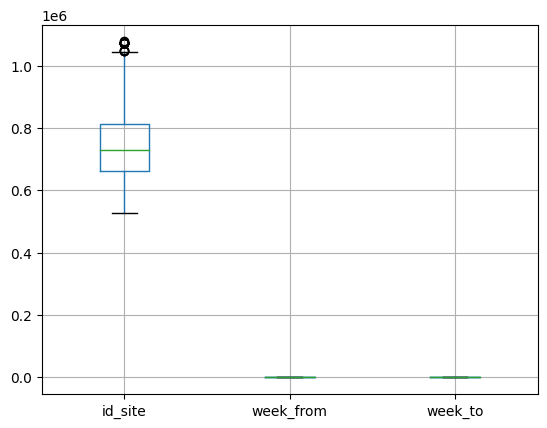

In [25]:
csv_basics(vle)

#### vle types

It would be nice to factor in vle type - however, from experience - `activity type` is often not a meaningful piece of data as it is not tightly defined or controlled.  I also do not know what they mean or how they differ.  

And because each module_presentation uses them differently, they are not possible for this iteration. 

In [26]:
group_vle = vle.groupby(['code_module', 'code_presentation', 'activity_type'])['id_site'].count().reset_index()
group_vle.rename(columns={'id_site': 'site_count'}, inplace=True)

# Print the results
print(group_vle)


print(vle['activity_type'].unique())

print(vle['activity_type'].value_counts())

    code_module code_presentation  activity_type  site_count
0           AAA             2013J       dataplus           4
1           AAA             2013J        forumng          15
2           AAA             2013J       glossary           2
3           AAA             2013J       homepage           1
4           AAA             2013J  oucollaborate           2
..          ...               ...            ...         ...
227         GGG             2014J       homepage           1
228         GGG             2014J      oucontent          26
229         GGG             2014J           quiz           8
230         GGG             2014J       resource          63
231         GGG             2014J        subpage           5

[232 rows x 4 columns]
['resource' 'oucontent' 'url' 'homepage' 'subpage' 'glossary' 'forumng'
 'oucollaborate' 'dataplus' 'quiz' 'ouelluminate' 'sharedsubpage'
 'questionnaire' 'page' 'externalquiz' 'ouwiki' 'dualpane'
 'repeatactivity' 'folder' 'htmlactivity']
reso